In [2]:
# installing pytorch
!pip install torch
!python -c "import torch; print(torch.__version__)"


#installing pytorch geometric
!pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  torch-cluster \
  -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html

#installing rdkit
!pip install rdkit-pypi

1.10.0+cu111
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 370 kB 5.4 MB/s 
     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 7.9 MB 25.5 MB/s 
     |████████████████████████████████| 2.3 MB 35.0 MB/s 
     |████████████████████████████████| 482 kB 45.1 MB/s 
     |████████████████████████████████| 41 kB 600 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581968 sha256=6a5e0f5cbe907c5be28041bffe137234cf486f1022e4c7439f32b3856d26d3bb
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built torch-geometric
     |████████████████████████████████| 20.4 MB 47.0 MB/s 


## Importing data and analyzing it

In [3]:
from torch_geometric.datasets import MoleculeNet
data = MoleculeNet(root=".", name="ESOL")

Processing...
Done!


In [4]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ')
Sample  nodes:  32
Sample  edges:  68


## Pytorch-Geometric model

In [5]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


## Training

In [6]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss() # use torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, batch.y))       
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 3.377596378326416
Epoch 100 | Train Loss 0.9627334475517273
Epoch 200 | Train Loss 1.072218656539917
Epoch 300 | Train Loss 0.638767659664154
Epoch 400 | Train Loss 0.38274532556533813
Epoch 500 | Train Loss 0.4588406980037689
Epoch 600 | Train Loss 0.4875830411911011
Epoch 700 | Train Loss 0.3256550431251526
Epoch 800 | Train Loss 0.35816076397895813
Epoch 900 | Train Loss 0.31040292978286743
Epoch 1000 | Train Loss 0.2475055456161499
Epoch 1100 | Train Loss 0.1682727336883545
Epoch 1200 | Train Loss 0.21468645334243774
Epoch 1300 | Train Loss 0.2138790786266327
Epoch 1400 | Train Loss 0.19109489023685455
Epoch 1500 | Train Loss 0.1968095600605011
Epoch 1600 | Train Loss 0.21863166987895966
Epoch 1700 | Train Loss 0.23082487285137177
Epoch 1800 | Train Loss 0.3015650808811188
Epoch 1900 | Train Loss 0.19388283789157867


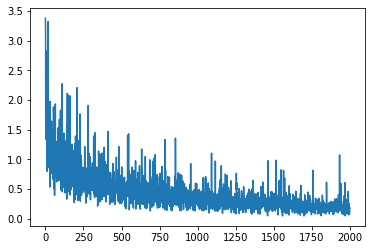

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
sns.lineplot(loss_indices, losses_float)
plt.show()

## ZINC dataset

In [8]:
from torch_geometric.datasets import ZINC
data = ZINC(root = '.')


Extracting ./molecules.zip
Processing...
Processing test dataset: 100%|██████████| 5000/5000 [00:00<00:00, 8772.96it/s] 
Done!


In [9]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.zinc.ZINC'>
Dataset features:  1
Dataset target:  218362
Dataset length:  <bound method InMemoryDataset.len of ZINC(220011)>
Dataset sample:  Data(x=[33, 1], edge_index=[2, 72], edge_attr=[72], y=[1])
Sample  nodes:  33
Sample  edges:  72


In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(1, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  12737


In [11]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, batch.y))       
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(20):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 2 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 2.834458112716675
Epoch 2 | Train Loss 2.479088544845581
Epoch 4 | Train Loss 2.4101486206054688
Epoch 6 | Train Loss 1.3092743158340454
Epoch 8 | Train Loss 1.8261083364486694
Epoch 10 | Train Loss 1.0654610395431519
Epoch 12 | Train Loss 1.4480472803115845
Epoch 14 | Train Loss 5.456602573394775
Epoch 16 | Train Loss 1.861289143562317
Epoch 18 | Train Loss 2.3593173027038574


In [12]:
print("Starting training...")
for epoch in range(20):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 2 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 3.2991349697113037
Epoch 2 | Train Loss 1.7229862213134766
Epoch 4 | Train Loss 1.228234052658081
Epoch 6 | Train Loss 1.7237424850463867
Epoch 8 | Train Loss 2.6074130535125732
Epoch 10 | Train Loss 1.3801002502441406
Epoch 12 | Train Loss 1.598260521888733
Epoch 14 | Train Loss 1.727259635925293
Epoch 16 | Train Loss 1.5225437879562378
Epoch 18 | Train Loss 0.8487586379051208


In [13]:
print("Starting training...")
for epoch in range(20):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 2 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 1.5556533336639404
Epoch 2 | Train Loss 1.3677154779434204
Epoch 4 | Train Loss 1.1134958267211914
Epoch 6 | Train Loss 1.1324230432510376
Epoch 8 | Train Loss 2.368504047393799
Epoch 10 | Train Loss 2.1689822673797607
Epoch 12 | Train Loss 1.5967885255813599
Epoch 14 | Train Loss 1.3123024702072144
Epoch 16 | Train Loss 2.7762234210968018
Epoch 18 | Train Loss 1.855214238166809


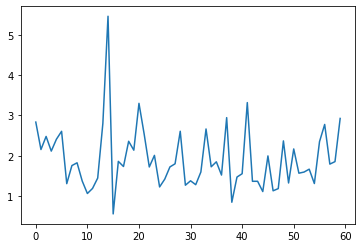

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
sns.lineplot(loss_indices, losses_float)
plt.show()